# Identification of gene regulatory network from gene expression time-course data

In [167]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [168]:
df = pd.read_csv("Assignment-gene-expression.csv",sep=";")
df.head()


,time,SWI5,CBF1,GAL4,GAL80,ASH1
0,0,0.0760,0.0419,0.0207,0.0225,0.1033
1,10,0.0186,0.0365,0.0122,0.0175,0.0462
2,20,0.0090,0.0514,0.0073,0.0165,0.0439
3,30,0.0117,0.0473,0.0079,0.0147,0.0371
4,40,0.0088,0.0482,0.0084,0.0145,0.0475


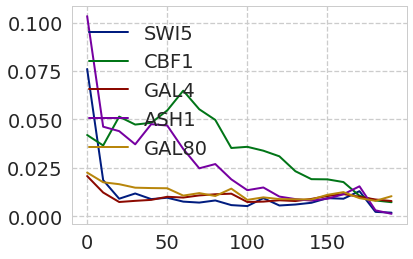

In [169]:
# Ploting the datas
t = df["time"]
plt.plot(t,df['SWI5'],label='SWI5')
plt.plot(t,df['CBF1'],label='CBF1')
plt.plot(t,df['GAL4'],label='GAL4')
plt.plot(t,df['ASH1'],label='ASH1')
plt.plot(t,df['GAL80'],label='GAL80')


plt.legend(loc='upper left')

# Linear regression model

In [5]:
# Compute finite differences for each gene

def finite_diff(x,y,dt):
    return (y-x)/dt

df_finite_diff_col = ['dSWI5','dCBF1','dGAL4','dGAL80','dASH1']
df_finite_diff = pd.DataFrame(np.zeros(shape=(len(df['time']),5)),columns=df_finite_diff_col)

for k in range(1,6):
    for i in range(len(df['time'])-1):
        df_finite_diff.iloc[i,k-1] = finite_diff(df.iloc[i,k],df.iloc[i+1,k],1)

df_finite_diff.head()

,dSWI5,dCBF1,dGAL4,dGAL80,dASH1
0,-0.0574,-0.0054,-0.0085,-0.0050,-0.0571
1,-0.0096,0.0149,-0.0049,-0.0010,-0.0023
2,0.0027,-0.0041,0.0006,-0.0018,-0.0068
3,-0.0029,0.0009,0.0005,-0.0002,0.0104
4,0.0007,0.0064,0.0016,-0.0001,-0.0007
5,-0.0020,0.0102,-0.0004,-0.0038,-0.0121
6,-0.0005,-0.0096,0.0011,0.0013,-0.0100
7,0.0011,-0.0055,0.0006,-0.0015,0.0022
8,-0.0024,-0.0145,0.0003,0.0038,-0.0079
9,-0.0005,0.0006,-0.0043,-0.0058,-0.0056


In [6]:
df_finite_diff.to_csv("finite_diff.csv")

# Boolean network

In [170]:
#Compute the correlation matrix

clean_df = df.iloc[:,1:]
d = np.array(clean_df.corr())
d

#11 possible edges

array([[ 1.        ,  0.15808084,  0.88063405,  0.7403462 ,  0.8332485 ],
       [ 0.15808084,  1.        ,  0.12921319,  0.44117441,  0.59050628],
       [ 0.88063405,  0.12921319,  1.        ,  0.68709773,  0.70923602],
       [ 0.7403462 ,  0.44117441,  0.68709773,  1.        ,  0.89656721],
       [ 0.8332485 ,  0.59050628,  0.70923602,  0.89656721,  1.        ]])

0.38095238095238093

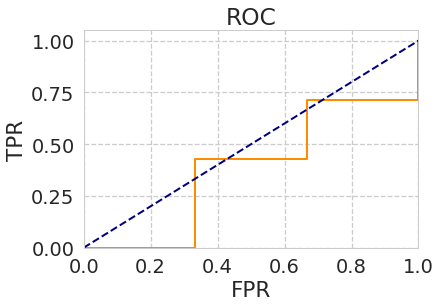

In [183]:
##### Boolean network learning algorithm using the correlation matrix #####
from sklearn import metrics

thresholds = np.linspace(0,1,100)
genes = clean_df.columns
true_network = [[0,1],[1,2],[2,0],[0,3],[0,4],[3,2],[4,1]]
true_negative = 10-len(true_network)
def sym_eq(x,y):
    return x == y or [x[1],x[0]] == y 

# Definig a dictionnary giving for each threshold the set of edges that are detected 
networks = {}
TPR = {}
FPR = {}
for t in thresholds:
    networks[t] = []
    TPR[t] = 0
    FPR[t] = 0
    for i in range(5):
        for j in range(i+1,5):
            if d[i][j] > t:
                networks[t] += [[i,j]]

# Computing TNR and FPR for each threshold
for t in thresholds:                
    if len(networks[t])>0:
            for x in networks[t]:
                x_in_true_network = 0
                for y in true_network:
                    if sym_eq(x,y):
                        x_in_true_network = 1
                        TPR[t] += 1/(len(true_network)*1.0)
                if x_in_true_network == 0:
                    FPR[t] += 1/(true_negative*1.0)
    else:
        TPR[t] = 0
        FPR[t] = 0

# Plotting ROC curve with seaborn

fpr = [FPR[t] for t in thresholds]
tpr = [TPR[t] for t in thresholds]

sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, font='Ricty',
rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

lw = 2
plt.figure()
plt.plot(np.sort(fpr), np.sort(tpr), color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")    

metrics.auc(fpr,tpr)

In [179]:
### Undirected Graph Model using multivariate Gaussian MRFs
from sklearn.covariance import empirical_covariance

cov = empirical_covariance(clean_df)
L = np.absolute(np.linalg.inv(cov))
L = L/(np.max(L))
L


array([[ 0.11245849,  0.03882343,  0.23105019,  0.14384677,  0.07779171],
       [ 0.03882343,  0.02600396,  0.03988844,  0.06727974,  0.0382702 ],
       [ 0.23105019,  0.03988844,  1.        ,  0.32272808,  0.099879  ],
       [ 0.14384677,  0.06727974,  0.32272808,  0.84926354,  0.19873616],
       [ 0.07779171,  0.0382702 ,  0.099879  ,  0.19873616,  0.08110579]])

0.4285714285714286

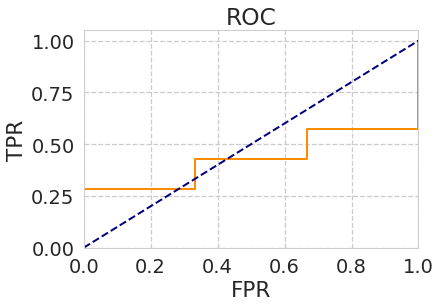

In [184]:
thresholds = np.linspace(0,1,100)
genes = clean_df.columns
true_network = [[0,1],[1,2],[2,0],[0,3],[0,4],[3,2],[4,1]]
true_negative = 10-len(true_network)
def sym_eq(x,y):
    return x == y or [x[1],x[0]] == y 

# Definig a dictionnary giving for each threshold the set of edges that are detected 
networks = {}
TPR = {}
FPR = {}
for t in thresholds:
    networks[t] = []
    TPR[t] = 0
    FPR[t] = 0
    for i in range(5):
        for j in range(i+1,5):
            if L[i][j] > t:
                networks[t] += [[i,j]]

# Computing TNR and FPR for each threshold
for t in thresholds:                
    if len(networks[t])>0:
            for x in networks[t]:
                x_in_true_network = 0
                for y in true_network:
                    if sym_eq(x,y):
                        x_in_true_network = 1
                        TPR[t] += 1/(len(true_network)*1.0)
                if x_in_true_network == 0:
                    FPR[t] += 1/(true_negative*1.0)
    else:
        TPR[t] = 0
        FPR[t] = 0

# Plotting ROC curve with seaborn

fpr = [FPR[t] for t in thresholds]
tpr = [TPR[t] for t in thresholds]

sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, font='Ricty',
rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

lw = 2
plt.figure()
plt.plot(np.sort(fpr), np.sort(tpr), color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")    

metrics.auc(fpr,tpr)

0.19047619047619047

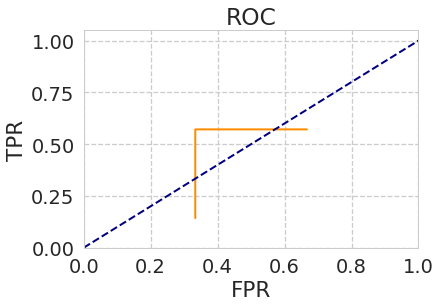

In [215]:
## Graphical Lasso
from sklearn.covariance import GraphLasso
from sklearn.model_selection import GridSearchCV

alpha = np.logspace(-6,-5,1000)

Lasso = GridSearchCV(GraphLasso(),{'alpha':alpha})
Lasso.fit(clean_df.values)

L = np.absolute(Lasso.best_estimator_.get_precision())
L =L/(np.max(L))

thresholds = np.linspace(0,0.1,10000)
genes = clean_df.columns
true_network = [[0,1],[1,2],[2,0],[0,3],[0,4],[3,2],[4,1]]
true_negative = 10-len(true_network)
def sym_eq(x,y):
    return x == y or [x[1],x[0]] == y 

# Definig a dictionnary giving for each threshold the set of edges that are detected 
networks = {}
TPR = {}
FPR = {}
for t in thresholds:
    networks[t] = []
    TPR[t] = 0
    FPR[t] = 0
    for i in range(5):
        for j in range(i+1,5):
            if L[i][j] > t:
                networks[t] += [[i,j]]

# Computing TNR and FPR for each threshold
for t in thresholds:                
    if len(networks[t])>0:
            for x in networks[t]:
                x_in_true_network = 0
                for y in true_network:
                    if sym_eq(x,y):
                        x_in_true_network = 1
                        TPR[t] += 1/(len(true_network)*1.0)
                if x_in_true_network == 0:
                    FPR[t] += 1/(true_negative*1.0)
    else:
        TPR[t] = 0
        FPR[t] = 0

# Plotting ROC curve with seaborn

fpr = [FPR[t] for t in thresholds]
tpr = [TPR[t] for t in thresholds]

sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, font='Ricty',
rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

lw = 2
plt.figure()
plt.plot(np.sort(fpr), np.sort(tpr), color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")    

metrics.auc(fpr,tpr)

In [210]:
L

array([[ 0.09371719,  0.0301191 ,  0.161688  ,  0.        ,  0.04948354],
       [ 0.0301191 ,  0.02689172,  0.        ,  0.01264928,  0.02950437],
       [ 0.161688  ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.01264928,  0.        ,  0.80330743,  0.11663597],
       [ 0.04948354,  0.02950437,  0.        ,  0.11663597,  0.0600749 ]])